<a href="https://colab.research.google.com/github/exolkitty/UTS_ML2019_Main/blob/master/ML_assignment_2_pdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IEEE-CIS Fraud Detection

## Introduction

In this assignment, machine learning models are benchmarked on challenging large-scale data sets. The data comes from Vesta's real-world e-commerce transactions, which include multiple functions from device type to product functionality. New features can be created to improve your results. If successful, it will increase the efficiency of millions of fraudulent transaction alerts around the world, helping thousands of businesses reduce fraud losses and increase revenue. Of course, troubles of the misunderstandings around us will be saved.

![](http://news.mit.edu/sites/mit.edu.newsoffice/files/styles/news_article_image_top_slideshow/public/images/2018/MIT-Fraud-Detection-PRESS_0.jpg?itok=laiU-5nR)

For offline transactions, you can build user cross-point plots to detect leaks (they use the same ATM or register on the same site). At the beginning of the fraudulent activity, we can assume that the entire team has been violated and taken precautions. For friendly fraud, the most naive approach is credit scoring (based on historical data). If the customer never asks for a refund, it is highly unlikely that he will do so through the transaction. These data are likely to be hidden in the V column.

Fraudsters often use large amounts of stolen data and use automated or semi-automated software to complete transactions. Although they try to imitate the behavior of real people, digital behavior is usually different from the real user. If we provide more information about digital footprint and user behavior, our model can see this. 

**What is fraud detection?**
> **Fraud detection** is a set of activities undertaken to prevent money or property from being obtained through false pretenses. Fraud detection is applied to many industries such as banking or insurance. In banking, fraud may include forging checks or using stolen credit cards. 

## Exploration

This project is a binary classification problem. Submissions are evaluated on **area under the ROC curve** between the predicted probability and the observed target. In practice, this means that only the order of predictions matter, as a result of this, any rescaling done to the model's output probabilities will have no effect on the score.

![](https://46gyn61z4i0t1u1pnq2bbk2e-wpengine.netdna-ssl.com/wp-content/uploads/2018/07/ROC-curve-1-360x296.jpg)

In this project, the possibility of online transactions being fraudulent is expected to predict, as indicated by the binary target isFraud. The data is divided into two files identity and transaction, and the two files are connected by TransactionID. Not all transactions have corresponding identity information.

The logic that data is tagged is to define the refund reported on the card as a fraudulent transaction (isFraud = 1), and the transaction that is directly associated with the user account, email address or billing address to these attributes is defined as fraud. If none of the above data was reported and discovered after 120 days, we define it as a legitimate transaction (isFraud = 0).

However, in the real world, fraudulent acts may not be reported, such as the cardholder is not aware of it, or has forgotten to report during the reporting period and beyond the time limit for the claim, in which case the presumed fraud may be Marked as legal, but we never know about them. Therefore, we consider them to be unusual cases that can be ignored.

## Method

Data collection is the first step in the machine learning process, which is collected from various sources. Data is also tagged in the context of supervised learning. The raw data tends to be rough or noisy. The data needs to be preprocessed to obtain effective training data. Unlike ordinary data mining, the data preprocessing process of deep learning mainly include data normalization (including sample size normalization), sample-by-sample mean subtraction, standardization) and data whitening.

In addition, in the pre-processing stage, we also need to divide the data into three data sets, including the training set used to train the model, the verification set of the user-adjusted in the development process, and the test set used in the test. Before we start the model training, we need to classify our training goals. Understanding the nature of the goal is critical to the way you choose to train. We tested the model with a test set prepared in data preprocessing. Since the test set is completely new to the model, it is possible to objectively measure the performance of the model in the real world.

![](./img/pipeline.png)

References:
- https://www.kaggle.com/jesucristo/fraud-complete-eda
- https://www.kaggle.com/mjbahmani/reducing-memory-size-for-ieee
- https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt

In [0]:
import os
import gc
import time
import datetime
import warnings
from contextlib import contextmanager

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import lightgbm as lgb
from sklearn import preprocessing, neighbors, svm
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score


sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

**Useful Functions**

In [0]:
# useful functions

@contextmanager
def timer(msg, prefix=""):
    t0 = time.time()
    print(f'{prefix}[{msg}] start.')
    yield
    elapsed_time = time.time() - t0
    print(f'{prefix}[{msg}] done in {elapsed_time / 60:.2f} min.\n')

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## EDA

### Data loading and overview

The data is broken into two files **transaction** and **identity**, which are joined by TransactionID.

> ps: Not all transactions have corresponding identity information.

In [0]:
os.listdir("./input")

['train_identity.csv',
 'test_identity.csv.zip',
 'train_transaction.csv',
 'test_identity.csv',
 'train_identity.csv.zip',
 'test_transaction.csv',
 'sample_submission.csv.zip',
 'test_transaction.csv.zip',
 'sample_submission.csv',
 'train_transaction.csv.zip']

In [0]:
%%time
data_path = "./input"
train_transaction = pd.read_csv(os.path.join(data_path, 'train_transaction.csv'), index_col='TransactionID')
test_transaction = pd.read_csv(os.path.join(data_path, 'test_transaction.csv'), index_col='TransactionID')
train_identity = pd.read_csv(os.path.join(data_path, 'train_identity.csv'), index_col='TransactionID')
test_identity = pd.read_csv(os.path.join(data_path, 'test_identity.csv'), index_col='TransactionID')
print ("Data is loaded!")

Data is loaded!
CPU times: user 25.1 s, sys: 712 ms, total: 25.9 s
Wall time: 25.9 s


In [0]:
print('Train transaction has {} rows and {} columns.'.format(train_transaction.shape[0],train_transaction.shape[1]))
print('Train identity has {} rows and {} columns.'.format(train_identity.shape[0],train_identity.shape[1]))
print('Test transaction has {} rows and {} columns.'.format(test_transaction.shape[0],test_transaction.shape[1]))
print('Test identity has {} rows and {} columns.'.format(test_identity.shape[0],test_identity.shape[1]))

Train transaction has 590540 rows and 393 columns.
Train identity has 144233 rows and 40 columns.
Test transaction has 506691 rows and 392 columns.
Test identity has 141907 rows and 40 columns.


In [0]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
train_identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [0]:
train_identity["id_14"].head(10)

TransactionID
2987004   -480.0
2987008   -300.0
2987010      NaN
2987011      NaN
2987016   -300.0
2987017   -300.0
2987022      NaN
2987038   -300.0
2987040      NaN
2987048      NaN
Name: id_14, dtype: float64

In [0]:
print("{}% of TransactionIDs in train have an associated train_identity.".format(round(np.sum(train_transaction.index.isin(train_identity.index.unique())) / train_transaction.shape[0] * 100)))
print("{}% of TransactionIDs in test have an associated train_identity.".format(round(np.sum(test_transaction.index.isin(test_identity.index.unique())) / test_transaction.shape[0] *100)))

24.0% of TransactionIDs in train have an associated train_identity.
28.0% of TransactionIDs in test have an associated train_identity.


In [0]:
%%time
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
del train_transaction, train_identity, test_transaction, test_identity

Mem. usage decreased to 648.22 Mb (66.8% reduction)
Mem. usage decreased to 563.43 Mb (66.3% reduction)
CPU times: user 53.2 s, sys: 18.8 s, total: 1min 11s
Wall time: 1min 11s


### Data Exploration

#### Target Distribution

Our original dataset is imbalanced. **Imbalance** means that the number of data points available for different the classes is different. Most transactions are not fraudulent. If we use this data frame as the basis for predictive models and analysis, there may be many errors, and our algorithm may overfit because it will "assume" that most transactions are not fraudulent. 

,0,1
isFraud,0.96501,0.03499


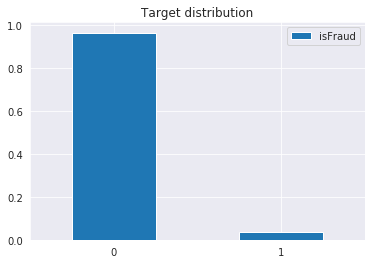

In [0]:
target_stats = train['isFraud'].value_counts(normalize=True).to_frame()
ax = target_stats.plot.bar(rot=0)
ax.set_title("Target distribution")
target_stats.T

#### Missing value

In [0]:
print('There are {} columns in train dataset with missing values.'.format(train.isnull().any().sum()))
all_missing_columns = train.columns[train.isnull().sum() == train.shape[0]]
print('{} columns missing all values'.format(len(all_missing_columns)))

There are 414 columns in train dataset with missing values.
0 columns missing all values


In [0]:
missing_count = train.isnull().sum()
missing_count[missing_count!=0]

card2              8933
card3              1565
card4              1577
card5              4259
card6              1571
addr1             65706
addr2             65706
dist1            352271
dist2            552913
P_emaildomain     94456
R_emaildomain    453249
D1                 1269
D2               280797
D3               262878
D4               168922
D5               309841
D6               517353
D7               551623
D8               515614
D9               515614
D10               76022
D11              279287
D12              525823
D13              528588
D14              528353
D15               89113
M1               271100
M2               271100
M3               271100
M4               281444
                  ...  
id_11            449562
id_12            446307
id_13            463220
id_14            510496
id_15            449555
id_16            461200
id_17            451171
id_18            545427
id_19            451222
id_20            451279
id_21           

Reference: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-627423

**Categorical Feature-Transaction**
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country
- addr1: billing region 
- addr2: billing country
- P_emaildomain: purchaser email domain
- R_emaildomain: recipient email domain
- M1 - M9

**Categorical Features - Identity**
- DeviceType
- DeviceInfo
- id_12 - id_38

note: 
Transaction: timedelta from a given reference datetime(not an actual timestamp). TransactionDT first value is 86400, which corresponds to the number of seconds in a day(60 * 60 * 24 = 86400)




#### ProductCD

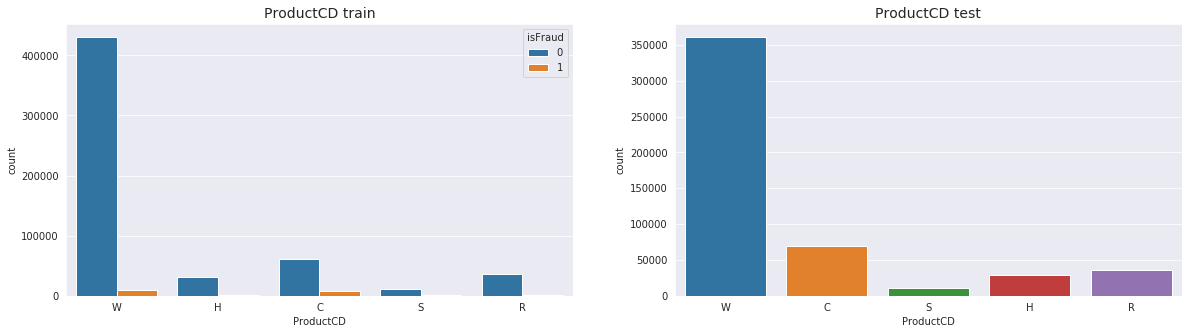

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.countplot(x="ProductCD", ax=ax[0], hue = "isFraud", data=train)
ax[0].set_title('ProductCD train', fontsize=14)
sns.countplot(x="ProductCD", ax=ax[1], data=test)
ax[1].set_title('ProductCD test', fontsize=14)
plt.show()

#### card1-card6

In [0]:
card_cols = [c for c in train.columns if 'card' in c]
train[card_cols].head()

,card1,card2,card3,card4,card5,card6
TransactionID,,,,,,
2987000,13926,NaN,150.0,discover,142.0,credit
2987001,2755,404.0,150.0,mastercard,102.0,credit
2987002,4663,490.0,150.0,visa,166.0,debit
2987003,18132,567.0,150.0,mastercard,117.0,debit
2987004,4497,514.0,150.0,mastercard,102.0,credit


Though we were told these cols are categorical features, some cols seem to be numerical.

In [0]:
print("Card Features Quantiles: ")
print(train[['card1', 'card2', 'card3', 'card5']].quantile([0.01, .025, .1, .25, .5, .75, .99]))

Card Features Quantiles: 
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.990  18238.0  583.0  185.0  226.0


Text(0, 0.5, 'Probability')

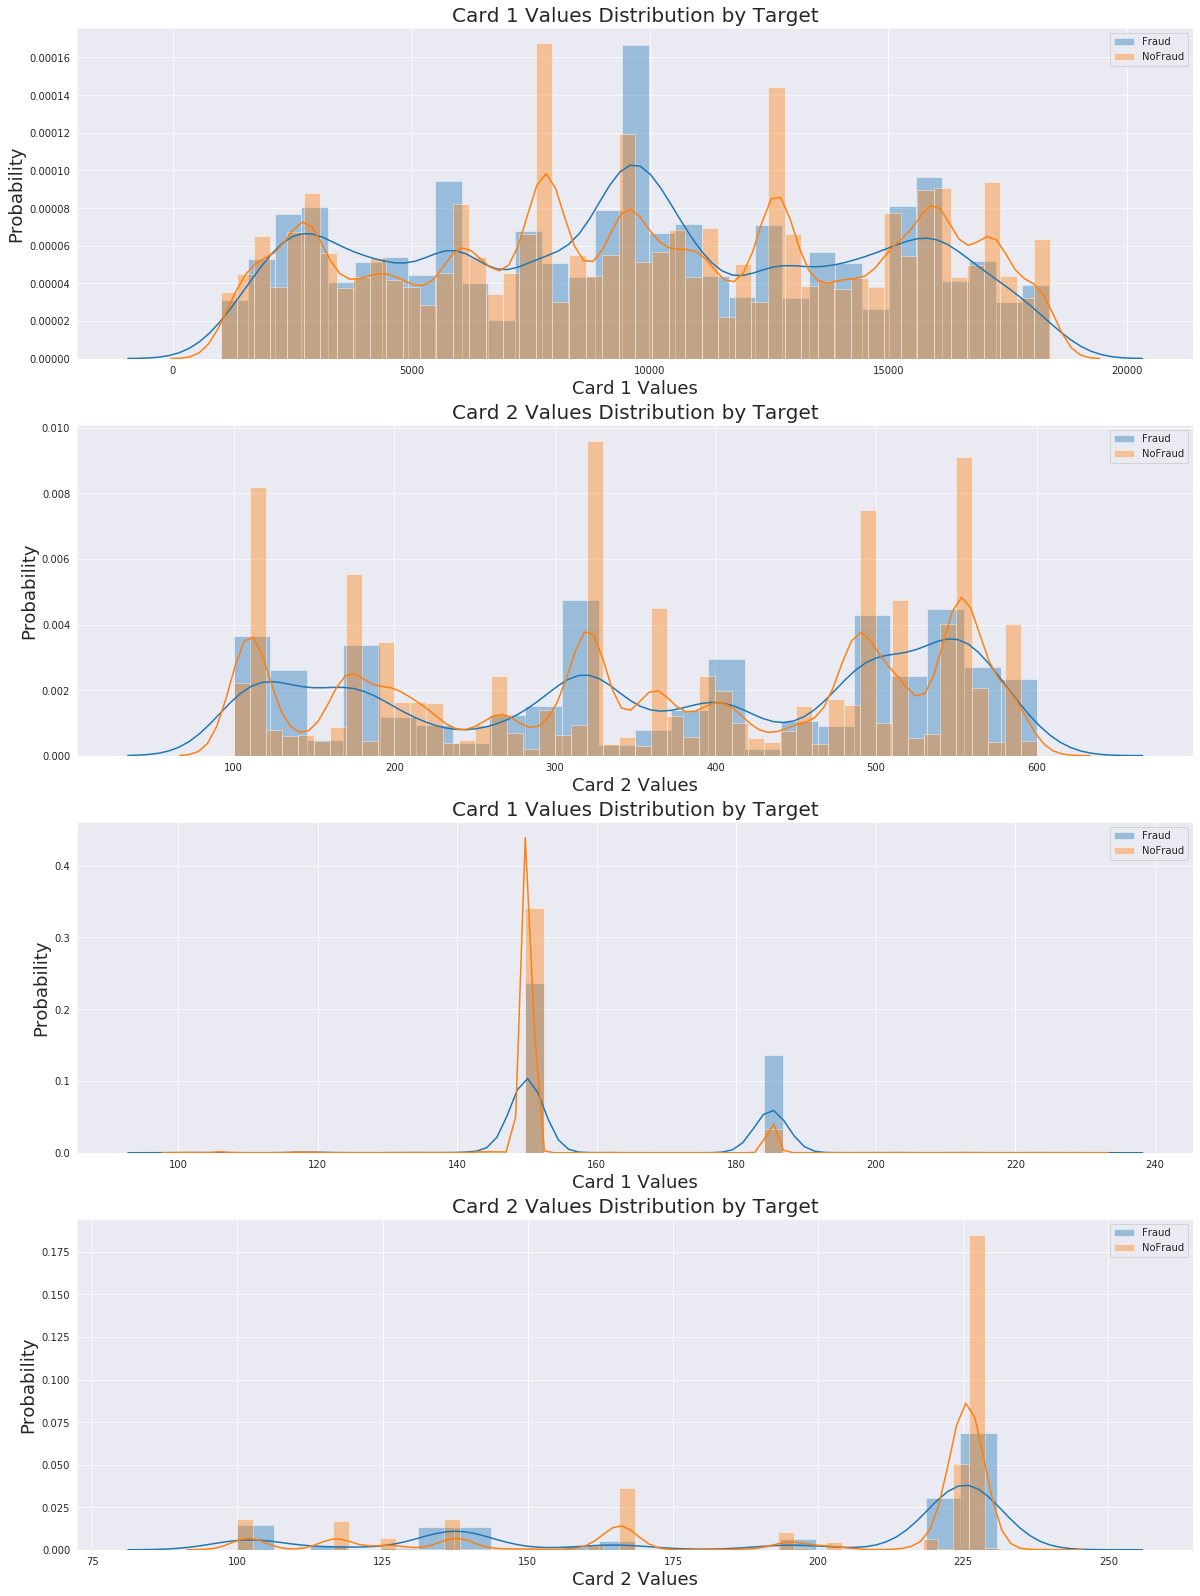

In [0]:
plt.figure(figsize=(20,28))

plt.subplot(411)
g = sns.distplot(train[train['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(train[train['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(train[train['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(train[train['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g = sns.distplot(train[train['isFraud'] == 1]['card3'].dropna(), label='Fraud')
g = sns.distplot(train[train['isFraud'] == 0]['card3'].dropna(), label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(414)
g1 = sns.distplot(train[train['isFraud'] == 1]['card5'].dropna(), label='Fraud')
g1 = sns.distplot(train[train['isFraud'] == 0]['card5'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

#### addr1 & addr2

In [0]:
addr_cols = [c for c in train.columns if 'addr' in c]
train[addr_cols].head()

,addr1,addr2
TransactionID,,
2987000,315.0,87.0
2987001,325.0,87.0
2987002,330.0,87.0
2987003,476.0,87.0
2987004,420.0,87.0


In [0]:
print("Addr Features Quantiles: ")
print(train[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .99]))

Addr Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.990  512.0   87.0


#### M1-M9

In [0]:
m_cols = [c for c in train if c[0] == 'M']
train[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987000,T,T,T,M2,F,T,NaN,NaN,NaN
2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2987002,T,T,T,M0,F,F,F,F,F
2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### DeviceType

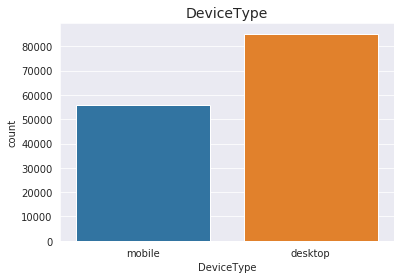

In [0]:
ax = sns.countplot(x="DeviceType", data=train)
ax.set_title('DeviceType', fontsize=14)
plt.show()

#### Device information

In [0]:
print ("Unique Devices = ",train['DeviceInfo'].nunique())
train['DeviceInfo'].value_counts().head(10)

Unique Devices =  1786


Windows                  47722
iOS Device               19782
MacOS                    12573
Trident/7.0               7440
rv:11.0                   1901
rv:57.0                    962
SM-J700M Build/MMB29K      549
SM-G610M Build/MMB29K      461
SM-G531H Build/LMY48B      410
rv:59.0                    362
Name: DeviceInfo, dtype: int64

**Numerical features**

#### TransactionDT

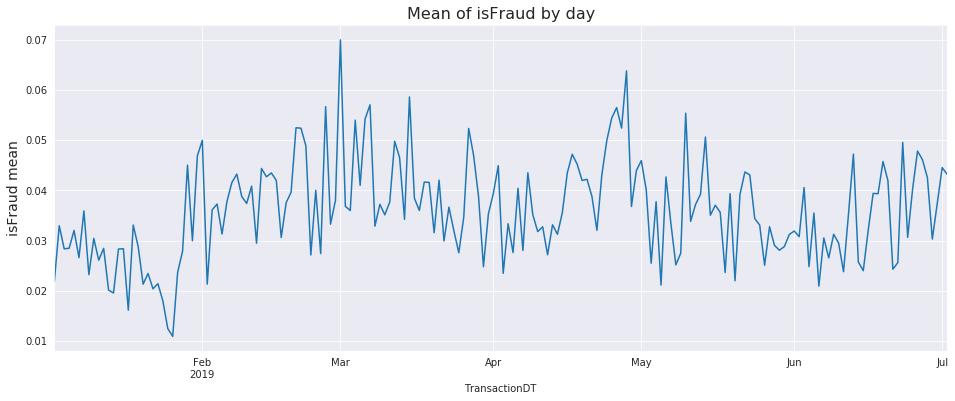

In [0]:
startdate = datetime.datetime.strptime('2019-01-01', '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=axes).set_ylabel('isFraud mean', fontsize=14);
axes.set_title('Mean of isFraud by day', fontsize=16);

#### TransactionAmt

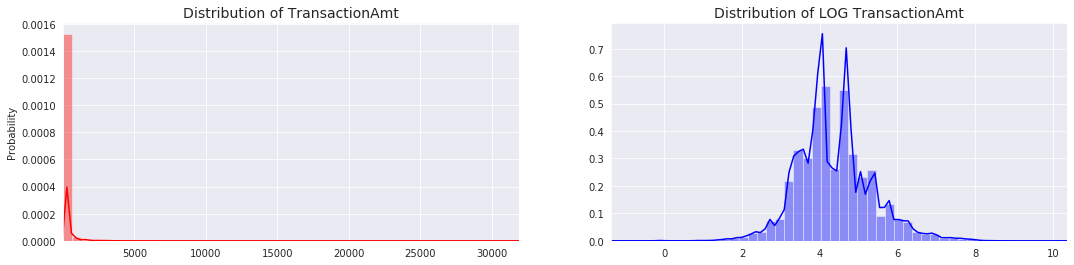

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amt_val = train['TransactionAmt'].values

sns.distplot(amt_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[0].set_ylabel("Probability")
ax[0].set_xlim([min(amt_val), max(amt_val)])

sns.distplot(np.log(amt_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(amt_val)), max(np.log(amt_val))])

plt.show()

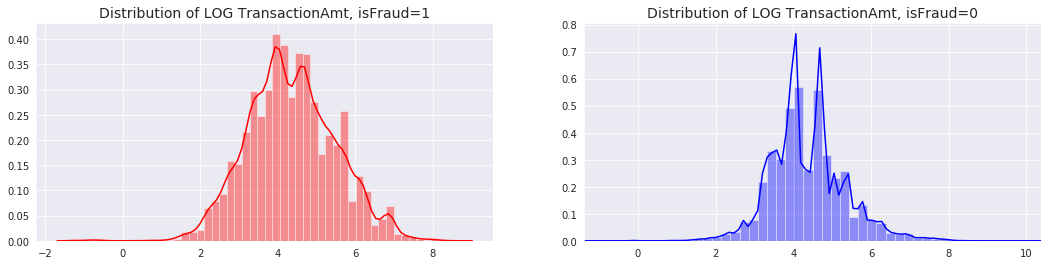

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amt_val = train.loc[train['isFraud'] == 1]['TransactionAmt'].values

sns.distplot(np.log(amt_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionAmt, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(amt_val)), max(np.log(amt_val))])

amt_val = train.loc[train['isFraud'] == 0]['TransactionAmt'].values

sns.distplot(np.log(amt_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(amt_val)), max(np.log(amt_val))])


plt.show()

### Feature engineering

#### Drop some columns

In [0]:
%%time
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()
y_train = train['isFraud'].astype("uint8").copy()

del train, test
gc.collect()

CPU times: user 508 ms, sys: 76 ms, total: 584 ms
Wall time: 583 ms


22641

In [0]:
%%time
# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))  

CPU times: user 37.5 s, sys: 0 ns, total: 37.5 s
Wall time: 37.5 s


In [0]:
drop_col = ['TransactionDT']
X_train.drop(drop_col,axis=1, inplace=True)
X_test.drop(drop_col, axis=1, inplace=True)
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,...,136,NaN,461,4,2,2,2,2,2,2740
2987001,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,...,136,NaN,461,4,2,2,2,2,2,2740
2987002,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,...,136,NaN,461,4,2,2,2,2,2,2740
2987003,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,...,136,NaN,461,4,2,2,2,2,2,2740
2987004,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,...,162,32.0,268,3,1,0,1,1,1,1565


#### Fill NaN

In [0]:
X_train.fillna(-999,inplace=True)
X_test.fillna(-999,inplace=True)
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,68.5,4,13926,-999.0,150.0,1,142.0,1,315.0,87.0,...,136,-999.0,461,4,2,2,2,2,2,2740
2987001,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,...,136,-999.0,461,4,2,2,2,2,2,2740
2987002,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,...,136,-999.0,461,4,2,2,2,2,2,2740
2987003,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,...,136,-999.0,461,4,2,2,2,2,2,2740
2987004,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,...,162,32.0,268,3,1,0,1,1,1,1565


In [0]:
X_train.shape, X_test.shape

((590540, 431), (506691, 431))

### Feature selection

In [0]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [0]:
# feature_selector = RFECV(lgb.LGBMClassifier(**params), step=10, scoring='roc_auc', cv=5, verbose=1)
# feature_selector.fit(X_train, y_train)
selected_features = [f for f in X_train.columns[feature_selector.ranking_ == 1]]
selected_features

['TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M8',
 'M9',
 'V5',
 'V12',
 'V13',
 'V19',
 'V20',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V44',
 'V45',
 'V53',
 'V54',
 'V55',
 'V56',
 'V61',
 'V62',
 'V66',
 'V67',
 'V70',
 'V75',
 'V76',
 'V77',
 'V78',
 'V82',
 'V83',
 'V86',
 'V87',
 'V91',
 'V96',
 'V99',
 'V102',
 'V124',
 'V126',
 'V127',
 'V128',
 'V129',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V136',
 'V137',
 'V139',
 'V143',
 'V160',
 'V165',
 'V170',
 'V171',
 'V187',
 'V189',
 'V201',
 'V203',
 'V208',
 'V209',
 'V210',
 'V212',
 'V217',
 'V221',
 'V231',
 'V256',
 'V257',
 'V258',
 'V261',
 'V264',
 'V265',
 'V266',
 'V2

## Model & Evaluation

### KNN

The proximity algorithm, or K-Nearest Neighbor classification algorithm, is one of the simplest methods in data mining classification technology. The so-called K nearest neighbor is the meaning of k nearest neighbors, saying that each sample can be represented by its nearest k neighbors.


The entire calculation process is divided into three steps:
- Calculate the distance between the object to be classified and other objects
- Count the nearest K neighbors
- For k nearest neighbors, which category they belong to the most, and which category of objects to be classified belong to

In [0]:
X_train_data, X_val_data, y_train_data, y_val_data = train_test_split(X_train[selected_features].iloc[:50000, :], y_train.iloc[:50000])
neighbors_num = np.arange(1,9)
train_accuracy =np.empty(len(neighbors_num))
dev_accuracy = np.empty(len(neighbors_num))
train_auc =np.empty(len(neighbors_num))
dev_auc = np.empty(len(neighbors_num))

with timer("Training"):
    for i,k in enumerate(neighbors_num):
        #Setup a knn classifier with k neighbors
        knn = neighbors.KNeighborsClassifier(n_neighbors=k)

        #Fit the model
        knn.fit(X_train_data, y_train_data)

        y_pred_train = knn.predict_proba(X_train_data)[:,1]
        y_pred_val = knn.predict_proba(X_val_data)[:,1]

        #Compute accuracy and auc on the training set
        train_accuracy[i] = knn.score(X_train_data, y_train_data)
        train_auc[i] = roc_auc_score(y_train_data, y_pred_train)

        #Compute accuracy and auc on the valid set
        dev_accuracy[i] = knn.score(X_val_data, y_val_data)
        dev_auc[i] = roc_auc_score(y_val_data, y_pred_val)

[Training] start.
[Training] done in 8.41 min.



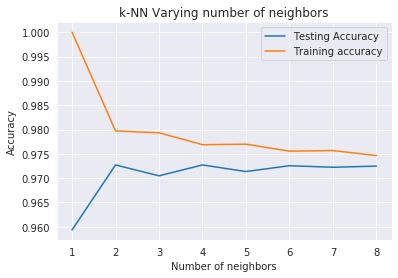

In [0]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors_num, dev_accuracy, label='Testing Accuracy')
plt.plot(neighbors_num, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

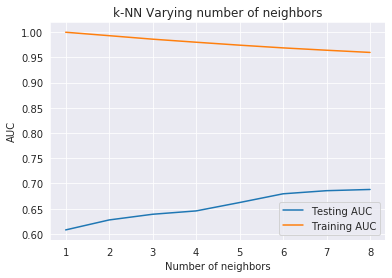

In [0]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors_num, dev_auc, label='Testing AUC')
plt.plot(neighbors_num, train_auc, label='Training AUC')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('AUC')
plt.show()

In [0]:
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]
train_accuracy =np.empty(len(distance_metrics))
dev_accuracy = np.empty(len(distance_metrics))
train_auc =np.empty(len(distance_metrics))
dev_auc = np.empty(len(distance_metrics))

with timer("Training"):
    for i, dist_metric in enumerate(distance_metrics):
        #Setup a knn classifier with k neighbors
        knn = neighbors.KNeighborsClassifier(n_neighbors=8, metric=dist_metric)

        #Fit the model
        knn.fit(X_train_data, y_train_data)

        y_pred_train = knn.predict_proba(X_train_data)[:,1]
        y_pred_val = knn.predict_proba(X_val_data)[:,1]

        #Compute accuracy and auc on the training set
        train_accuracy[i] = knn.score(X_train_data, y_train_data)
        train_auc[i] = roc_auc_score(y_train_data, y_pred_train)

        #Compute accuracy and auc on the valid set
        dev_accuracy[i] = knn.score(X_val_data, y_val_data)
        dev_auc[i] = roc_auc_score(y_val_data, y_pred_val)

[Training] start.
[Training] done in 4.95 min.



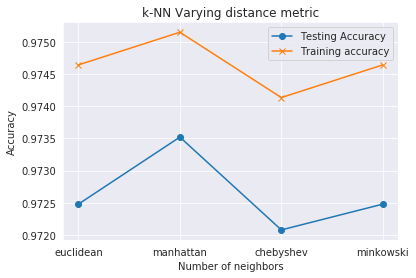

In [0]:
#Generate plot
plt.title('k-NN Varying distance metric')
plt.plot(distance_metrics, dev_accuracy, label='Testing Accuracy', marker="o")
plt.plot(distance_metrics, train_accuracy, label='Training accuracy', marker="x")
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

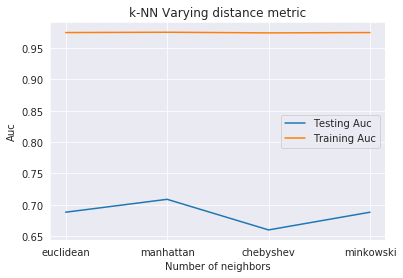

In [0]:
#Generate plot
plt.title('k-NN Varying distance metric')
plt.plot(distance_metrics, dev_auc, label='Testing Auc')
plt.plot(distance_metrics, train_accuracy, label='Training Auc')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Auc')
plt.show()

In [0]:
NFOLDS = 5
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=123)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
  
with timer("Training"):
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train[selected_features].iloc[:50000, :], y_train.iloc[:50000])):
        print('Training on fold {}'.format(fold + 1))
        clf = neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=4)

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        clf.fit(X_tr, y_tr)
        y_pred_train = clf.predict_proba(X_vl)[:,1]
        y_oof[val_idx] = y_pred_train
        print("FOLD: ",fold+1,' AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
        score += roc_auc_score(y_vl, y_pred_train) / NFOLDS
        y_preds+= clf.predict_proba(X_test)[:,1] / NFOLDS

        del X_tr, X_vl, y_tr, y_vl
        gc.collect()
    
    
print("\nMEAN AUC = {}".format(score))
print("OOF AUC = {}".format(roc_auc_score(y_train, y_oof)))

[Training] start.
Training on fold 1
FOLD:  1  AUC 0.6664561831516449
Training on fold 2
FOLD:  2  AUC 0.6746965938703573
Training on fold 3
FOLD:  3  AUC 0.7077873091404365
Training on fold 4
FOLD:  4  AUC 0.6808871033817246
Training on fold 5
FOLD:  5  AUC 0.6794136300738006
[Training] done in 28.01 min.


MEAN AUC = 0.6818481639235928
OOF AUC = 0.5107203084154263


Select a distance calculation method to calculate the distance between the test data and each training data. The distance calculation method generally selects Euclidean distance or Manhattan distance.

After calculating the distance between the test data and each training data, first sorting in increasing order of distance, and then selecting k points with the smallest distance.Generally, a smaller k value is selected first, and then cross-validation is performed to select an optimal k value. 

The accuracy of the KNN model is not high and the training speed is slow.

### Boosting (lightgbm)

GBDT is a widely used machine learning algorithm, which is widely used not only in data analysis competitions, but also widely used in industry. Due to the rapid growth of data volume, some researchers have tried to use the distributed to train GBDT, which in turn supports large-scale workloads. 

Integrated learning improves machine learning by combining multiple models, which produces better predictive performance than a single model. Integrated learning belongs to the meta-algorithm, which combines several "good and different" machine learning techniques to form a predictive model to reduce the variance, reduce the boosting, and improve the prediction accuracy.

The idea of the integrated approach is to create a strong learner (integrated model) by combining these deviations or variances of the learner for better performance.

In [0]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [0]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time.time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train, y_train)):
    start_time = time.time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y_train.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time.time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time.time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999921	valid_1's auc: 0.902097
Early stopping, best iteration is:
[753]	training's auc: 0.999469	valid_1's auc: 0.902713
Fold 1 finished in 0:00:41.379919
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999566	valid_1's auc: 0.922353
Early stopping, best iteration is:
[899]	training's auc: 0.999264	valid_1's auc: 0.922631
Fold 2 finished in 0:01:42.375353
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.997922	valid_1's auc: 0.91479
Early stopping, best iteration is:
[847]	training's auc: 0.996473	valid_1's auc: 0.915198
Fold 3 finished in 0:02:38.827434
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.995067	valid_1's auc: 0.934397
Early stopping, best iteration is:
[1154]	training's auc: 0.996565	valid_1's 

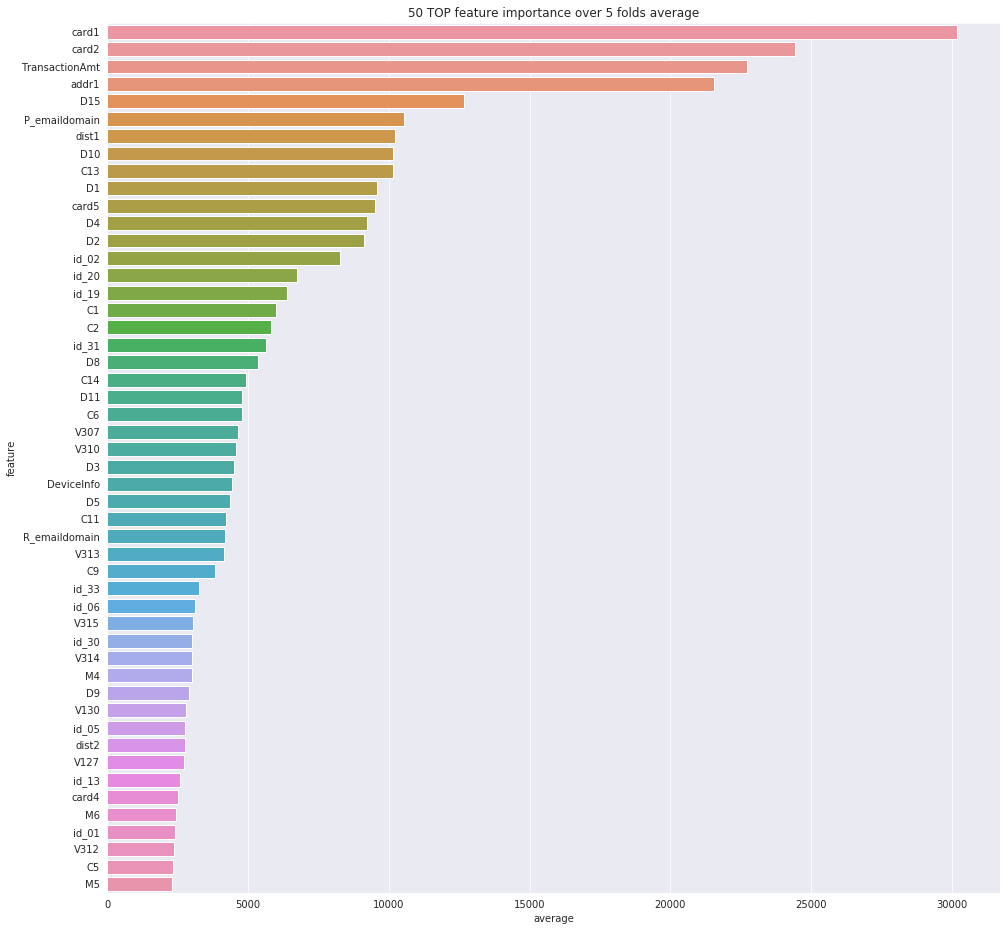

In [0]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

Choosing top 50 important features to build the model again.

In [0]:
feature_50 = feature_importances.sort_values(by='average', ascending=False).head(50)["feature"].tolist()

folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time.time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train[feature_50], y_train)):
    start_time = time.time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y_train.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time.time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time.time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999921	valid_1's auc: 0.902097
Early stopping, best iteration is:
[753]	training's auc: 0.999469	valid_1's auc: 0.902713
Fold 1 finished in 0:00:41.376801
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999566	valid_1's auc: 0.922353
Early stopping, best iteration is:
[899]	training's auc: 0.999264	valid_1's auc: 0.922631
Fold 2 finished in 0:01:42.586585
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.997922	valid_1's auc: 0.91479
Early stopping, best iteration is:
[847]	training's auc: 0.996473	valid_1's auc: 0.915198
Fold 3 finished in 0:02:38.562782
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.995067	valid_1's auc: 0.934397
Early stopping, best iteration is:
[1154]	training's auc: 0.996565	valid_1's 

## Conclusion

We achieved the same excellent results while using fewer parameters.

**The advantages of LightGBM**

- Faster training speed and higher efficiency: LightGBM uses a histogram-based algorithm. For example, it loads successive feature value buckets into discrete bins, which is faster during training.

- Lower memory footprint: Using discrete bins to save and replace consecutive values results in less memory usage.

- Higher accuracy (compared to any other lifting algorithm): It produces a more complex tree than the level-wise splitting method by the leaf-wise splitting method, which is the main factor for achieving higher accuracy. However, it sometimes causes overfitting, but we can prevent overfitting by setting the max-depth parameter.

**Future plan**
- Further, solve the problem of data imbalance.
- Optimization parameter
- Mining features to know more

## Ethical Analysis
**Machine learning (ML) models can be biased - essentially influenced by humans**

Although machine learning and artificial intelligence are promising, its models are also susceptible to unintentional bias.
In addition, in the decision-making process, the ML model may also have deviations when processing data. Do you provide incomplete data (one-sided data), and will the machine give the correct results?

**Interpretation of output error data can be difficult**

Interpretation of output error data is another risk that machine learning may face in the future. Imagine, after working so hard to get good data, you decide to share the results with another person - maybe your boss.
The same data results, your boss's explanation may be inconsistent with your own point of view. After all, his thinking process is different from yours, so his opinions are different from yours.

This happens often. That's why data scientists should not only pay attention when building models, but should also pay attention to understanding and correctly interpreting the “every point” of the output from any design model.

**AI and ML have not been scientifically explained**

In the true sense, many scientists are still trying to fully understand what AI and ML are. Although they have not yet gained a foothold in emerging markets, many researchers and data scientists are still working hard to learn more.
Many people are still scared because they believe there are still some unknown risks to be understood.
Even large technology companies like Google and Microsoft are still not.

The artificial intelligence chat robot Tay Ai was released by Microsoft on March 23, 2016. It was posted via twitter to interact with twitter users - but unfortunately it is considered racist. It was closed within 24 hours.

